# Zadania - deep learning, projekt 1

Karol Widuch   - widuch@student.agh.edu.pl

Konrad Kalita  - konradkalita@student.agh.edu.pl

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Trening klasycznych klasyfikatorów i sieci dla danych z wyrównaniem

##### helper functions

In [15]:
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

def showOpencvImage(image, title="", isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.axis("off")
    plt.imshow(image, cmap = 'gray')
    plt.show()
    
    
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

In [16]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

70000


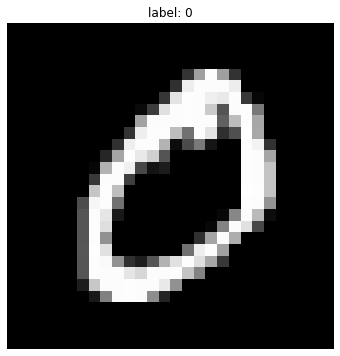

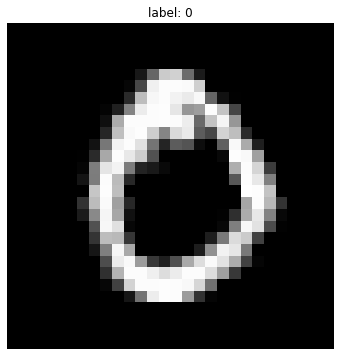

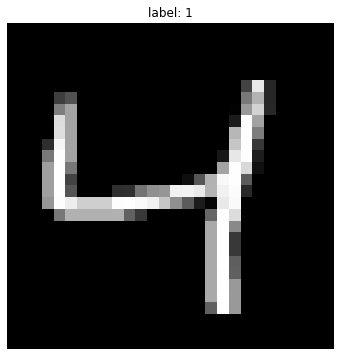

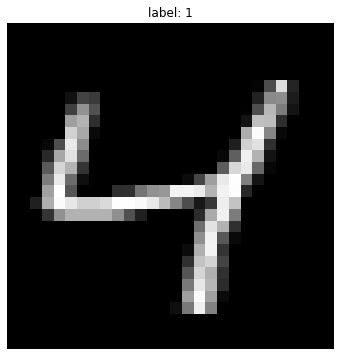

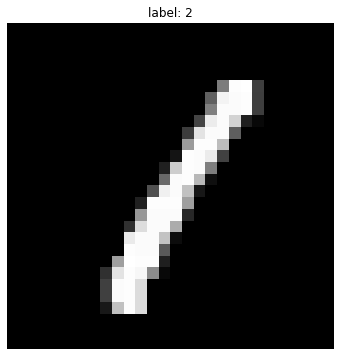

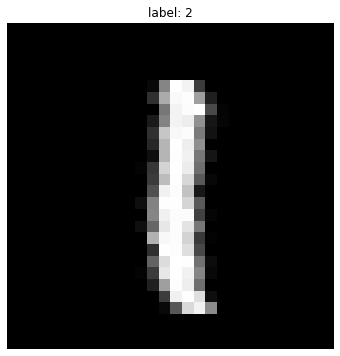

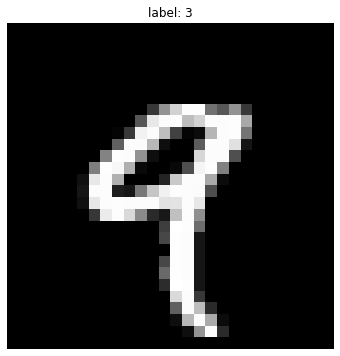

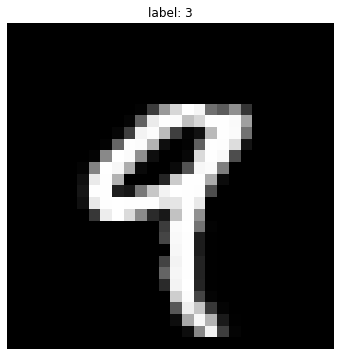

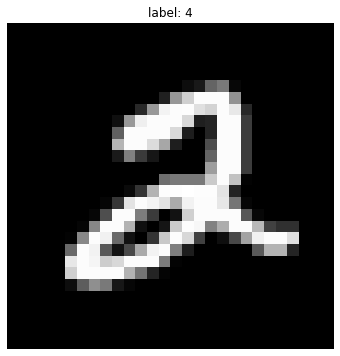

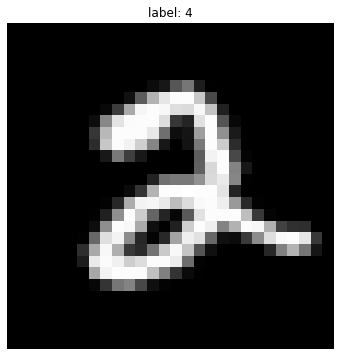

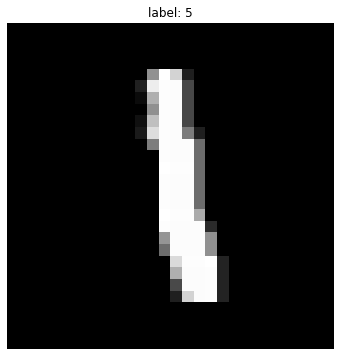

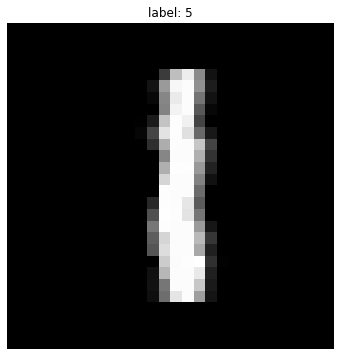

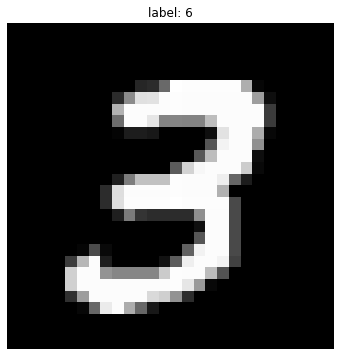

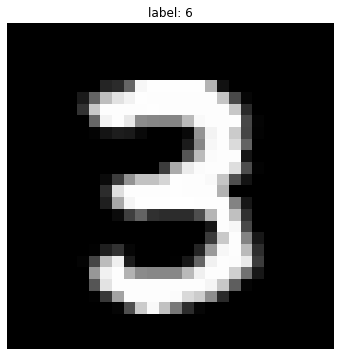

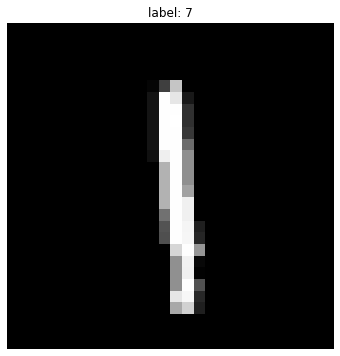

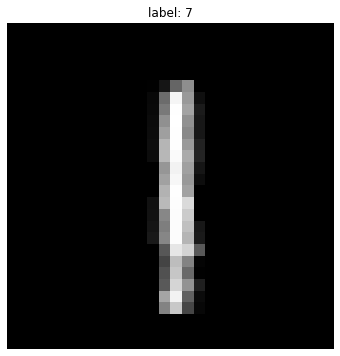

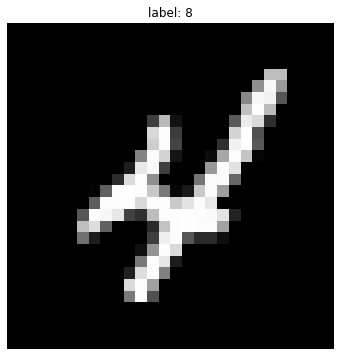

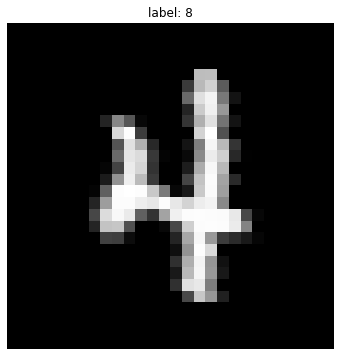

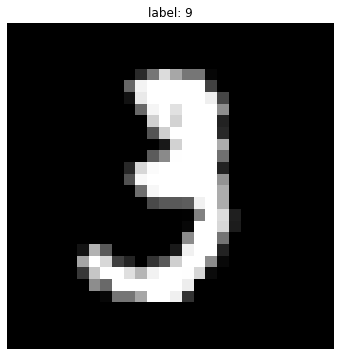

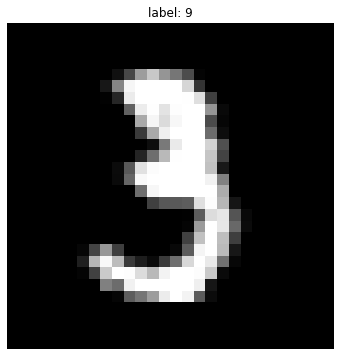

In [17]:
im_list = [train_images[i] for i in range(len(train_images))] + [test_images[i] for i in range(len(test_images))]
print(len(im_list))

train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]

train_deskewed = np.asarray(train_deskewed)
test_deskewed = np.asarray(test_deskewed)


for i in range(10):
    showOpencvImage(train_images[i+1], title=f"label: {i}")

    showOpencvImage(train_deskewed[i+1], title=f"label: {i}")

In [30]:
hog_train = [openCVHOG(im) for im in train_deskewed]
hog_test = [openCVHOG(im) for im in test_deskewed]
print("#########################\nTrain:\n#########################")
print(len(hog_train))
print(hog_train[0].shape)
train_data = np.float32(hog_train).reshape(-1,81)
print(train_data.shape)
print("#########################\nTest:\n#########################")
print(len(hog_test))
print(hog_test[0].shape)
test_data = np.float32(hog_test).reshape(-1,81)
print(test_data.shape)

#########################
Train:
#########################
60000
(81,)
(60000, 81)
#########################
Test:
#########################
10000
(81,)
(10000, 81)


In [31]:
model = svm.SVC(C=15.5,gamma=0.7)
model = model.fit(train_data[0:1000,:],train_labels[0:1000])

pred_labels = model.predict(test_data[0:500,:])

In [35]:
mask = pred_labels==test_labels[0:500]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels[0:500], pred_labels)
print(cm)
print(classification_report(test_labels[0:500], pred_labels))

94.2
[[41  0  0  0  1  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 53  0  0  0  1  1  0  0]
 [ 0  0  1 42  0  2  0  0  0  0]
 [ 0  0  0  0 54  0  1  0  0  0]
 [ 0  0  0  0  0 48  1  1  0  0]
 [ 0  0  0  0  0  1 42  0  0  0]
 [ 0  0  3  1  0  0  0 44  0  1]
 [ 1  0  0  1  1  2  0  0 32  3]
 [ 0  0  0  0  2  1  1  0  2 48]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       1.00      1.00      1.00        67
           2       0.93      0.96      0.95        55
           3       0.95      0.93      0.94        45
           4       0.93      0.98      0.96        55
           5       0.89      0.96      0.92        50
           6       0.91      0.98      0.94        43
           7       0.96      0.90      0.93        49
           8       0.94      0.80      0.86        40
           9       0.92      0.89      0.91        54

    accuracy                           0.94       500
   macro avg  

In [37]:
rfc =  RandomForestClassifier(max_depth=15, n_estimators=100, max_features=60)
rfc = rfc.fit(train_data[0:1000,:],train_labels[0:1000])

pred_labels = rfc.predict(test_data[0:500,:])

mask = pred_labels==test_labels[0:500]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels[0:500], pred_labels)
print(cm)
print(classification_report(test_labels[0:500], pred_labels))

91.2
[[41  0  0  0  0  0  0  0  0  1]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  2 50  0  1  0  0  2  0  0]
 [ 0  0  2 39  0  2  0  2  0  0]
 [ 0  0  0  0 54  0  1  0  0  0]
 [ 1  0  0  0  0 48  0  0  0  1]
 [ 1  0  0  0  0  2 40  0  0  0]
 [ 0  0  3  1  0  0  0 45  0  0]
 [ 0  1  0  2  2  2  0  1 26  6]
 [ 0  0  1  0  2  1  1  1  2 46]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.96      1.00      0.98        67
           2       0.89      0.91      0.90        55
           3       0.93      0.87      0.90        45
           4       0.92      0.98      0.95        55
           5       0.87      0.96      0.91        50
           6       0.95      0.93      0.94        43
           7       0.88      0.92      0.90        49
           8       0.93      0.65      0.76        40
           9       0.85      0.85      0.85        54

    accuracy                           0.91       500
   macro avg  

### Klasyczne klasyfikatory bez wyrównania

In [39]:
hog_train = [openCVHOG(im) for im in train_images]
hog_test = [openCVHOG(im) for im in test_images]
train_data = np.float32(hog_train).reshape(-1,81)
test_data = np.float32(hog_test).reshape(-1,81)

In [40]:
model = svm.SVC(C=15.5,gamma=0.7)
model = model.fit(train_data[0:1000,:],train_labels[0:1000])
pred_labels = model.predict(test_data[0:500,:])

mask = pred_labels==test_labels[0:500]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels[0:500], pred_labels)
print(cm)
print(classification_report(test_labels[0:500], pred_labels))

93.4
[[40  0  0  0  1  0  0  0  0  1]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 53  0  0  0  1  1  0  0]
 [ 0  0  1 42  0  2  0  0  0  0]
 [ 0  0  0  0 51  1  3  0  0  0]
 [ 0  1  0  0  0 47  0  1  1  0]
 [ 1  0  0  0  0  0 40  0  2  0]
 [ 0  0  2  1  0  0  0 46  0  0]
 [ 1  0  0  2  1  2  1  0 32  1]
 [ 0  0  0  0  0  1  0  1  3 49]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        42
           1       0.99      1.00      0.99        67
           2       0.95      0.96      0.95        55
           3       0.93      0.93      0.93        45
           4       0.96      0.93      0.94        55
           5       0.89      0.94      0.91        50
           6       0.89      0.93      0.91        43
           7       0.94      0.94      0.94        49
           8       0.84      0.80      0.82        40
           9       0.96      0.91      0.93        54

    accuracy                           0.93       500
   macro avg  

In [41]:
rfc =  RandomForestClassifier(max_depth=15, n_estimators=100, max_features=60)
rfc = rfc.fit(train_data[0:1000,:],train_labels[0:1000])

pred_labels = rfc.predict(test_data[0:500,:])

mask = pred_labels==test_labels[0:500]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels[0:500], pred_labels)
print(cm)
print(classification_report(test_labels[0:500], pred_labels))

86.2
[[40  0  0  0  1  0  1  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 3  0 45  1  1  0  1  3  0  1]
 [ 0  0  0 38  0  4  0  0  2  1]
 [ 0  1  0  0 50  0  3  0  0  1]
 [ 0  0  0  2  1 44  0  1  2  0]
 [ 1  0  0  0  5  2 34  0  1  0]
 [ 0  0  3  3  0  0  0 43  0  0]
 [ 2  0  0  2  2  4  0  0 25  5]
 [ 1  0  1  0  1  0  1  2  3 45]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        42
           1       0.99      1.00      0.99        67
           2       0.92      0.82      0.87        55
           3       0.83      0.84      0.84        45
           4       0.82      0.91      0.86        55
           5       0.81      0.88      0.85        50
           6       0.85      0.79      0.82        43
           7       0.88      0.88      0.88        49
           8       0.76      0.62      0.68        40
           9       0.85      0.83      0.84        54

    accuracy                           0.86       500
   macro avg  